In [1]:
import sys  
sys.path.append('/home/ross/CHADBiomarkers')
from multivariate_models import *
from statistics_utils import *
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
sns.set(style="white", font_scale=1.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

<h1>Multivariate logistic regression (complete case)</h1>

<h1>Load and prepare dataset</h1>

In [2]:
data = pd.read_csv("../covid_mortality_predictors.csv")

In [3]:
features = ["age",
"gender",
"wimd",
"Creatinine",
"Neutrophils:Lymphocytes",
"C-reactive protein (CRP)",
"Albumin",
"Urea"]
extended_panel = ["High Sensitivity Troponin I",
"Lactate dehydrogenase",
"Ferritin",
"Procalcitonin",
"D-dimer"]
endpoints = ["death", "composite"]

In [4]:
data = data[features + endpoints + extended_panel].dropna()

<ipython-input-8-6c82c6ebd58a>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


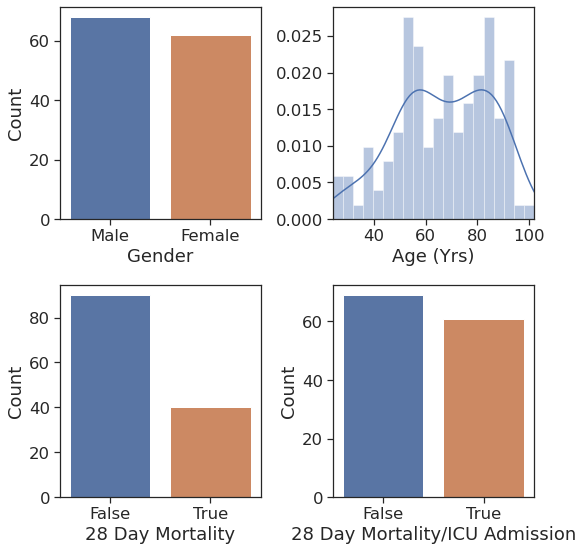

In [8]:
fig, axes = inspect_class_imbalance(data)
fig.savefig("../figures/complete_case/demographics.svg", facecolor="white", bbox_inches="tight")
fig.show()

<h1>Logistic regression with StatsModels</h1>

<h2>28 Day Mortality</h2>

<h3>Stratified K-folds</h3>

In [9]:
models = defaultdict(list)
skf = StratifiedKFold(n_splits=5, shuffle=False)
print("================================")
print("Base Model...")
for train_idx, test_idx in skf.split(data[features], data["death"]):
    X_train = data[features].values[train_idx]
    y_train = data["death"].values[train_idx]
    X_test = data[features].values[test_idx]
    y_test = data["death"].values[test_idx]
    models["Basic model"].append(fit_and_predict(X_train, X_test, y_train, y_test))
for e in extended_panel:
    updated_features = features + [e]
    print(f"{e}...")
    for train_idx, test_idx in skf.split(data[updated_features], data["death"]):
        X_train = data[updated_features].values[train_idx]
        y_train = data["death"].values[train_idx]
        X_test = data[updated_features].values[test_idx]
        y_test = data["death"].values[test_idx]
        models[e].append(fit_and_predict(X_train, X_test, y_train, y_test))
print("Complex model...")
updated_features = features + extended_panel
for train_idx, test_idx in skf.split(data[updated_features], data["death"]):
    X_train = data[updated_features].values[train_idx]
    y_train = data["death"].values[train_idx]
    X_test = data[updated_features].values[test_idx]
    y_test = data["death"].values[test_idx]
    models["Complex model"].append(fit_and_predict(X_train, X_test, y_train, y_test))
print("Complete!")
print("================================")

Base Model...
High Sensitivity Troponin I...
Lactate dehydrogenase...
Ferritin...
Procalcitonin...
D-dimer...
Complex model...
Complete!


<h3>Learning Curves</h3>

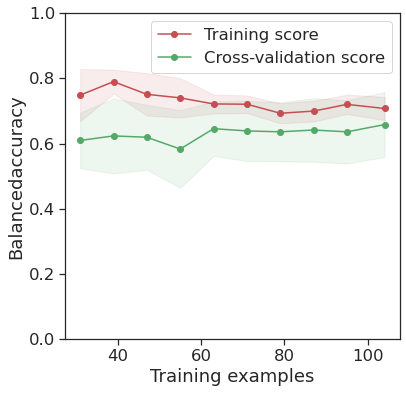

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_learning_curve(data=data, features=features, label="death",
                    ax=ax)
fig.savefig("../figures/complete_case/learning_curves/mortality/basic_model.svg", 
            facecolor="white", bbox_inches="tight")

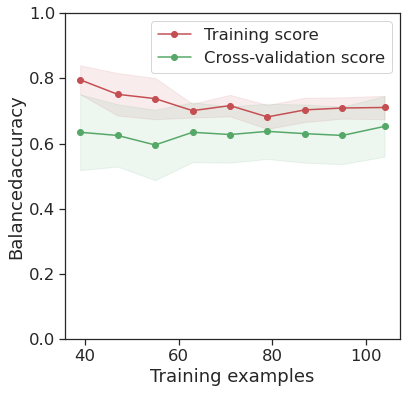

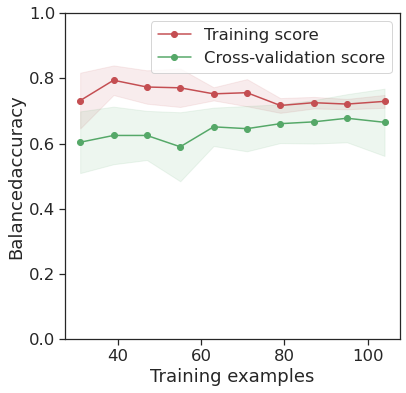

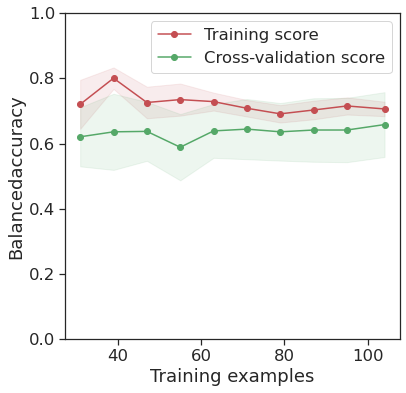

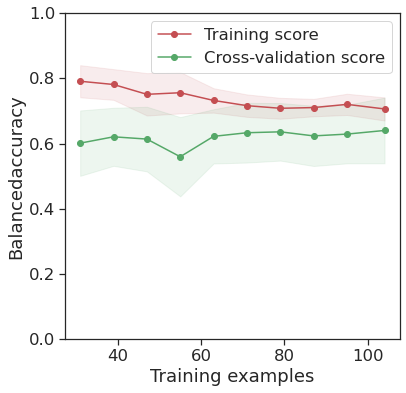

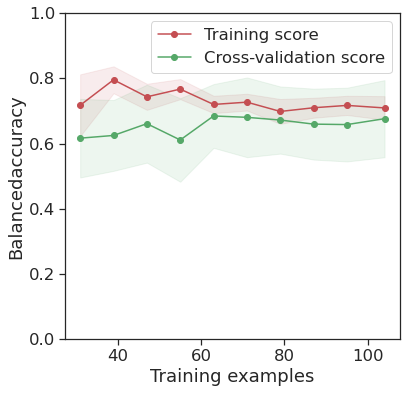

In [11]:
for e in extended_panel:
    updated_features = features + [e]
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_learning_curve(data=data, features=updated_features, label="death",
                        ax=ax)
    fig.savefig(f"../figures/complete_case/learning_curves/mortality/{e}.svg", 
                facecolor="white", bbox_inches="tight")

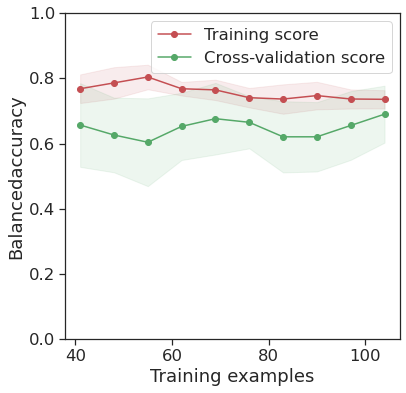

In [12]:
updated_features = features + extended_panel
fig, ax = plt.subplots(figsize=(6, 6))
plot_learning_curve(data=data, features=updated_features, label="death",
                    ax=ax, train_sizes=np.linspace(0.4, 1, 10))
fig.savefig(f"../figures/complete_case/learning_curves/mortality/complex_model.svg", 
            facecolor="white", bbox_inches="tight")

<h3>Model performance</h3>

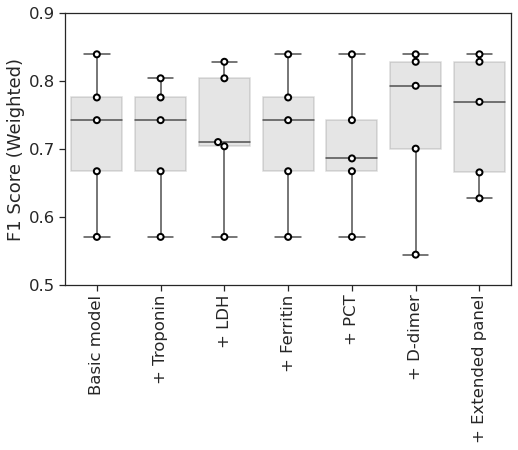

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
box_swarm_models(models, "F1 Score (Weighted)", ax, ylim=(0.5, 0.9), swarm_size=6)
fig.savefig("../figures/complete_case/mortality_f1score.svg", 
            facecolor="white", bbox_inches="tight")

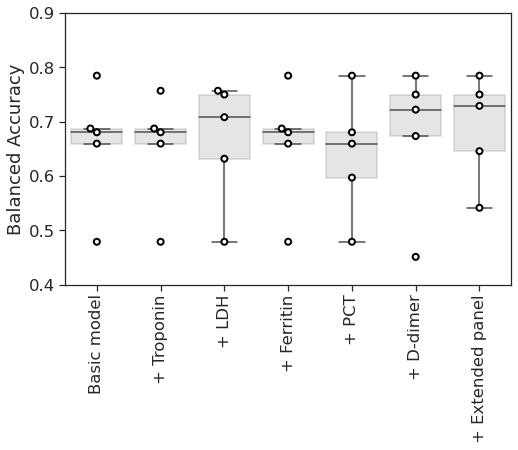

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
box_swarm_models(models, "Balanced Accuracy", ax, ylim=(0.4, 0.9), swarm_size=6)
fig.savefig("../figures/complete_case/mortality_acc.svg", 
            facecolor="white", bbox_inches="tight")

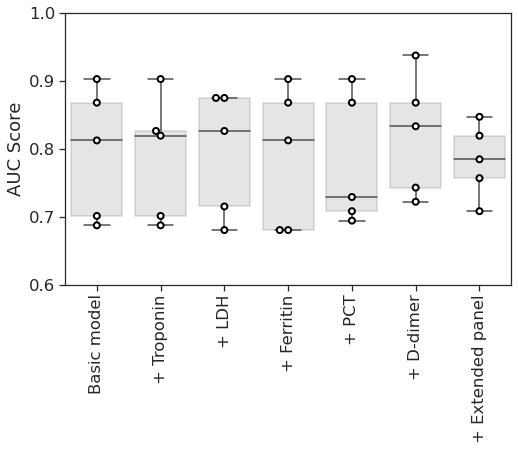

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
box_swarm_models(models, "AUC Score", ax, ylim=(0.6, 1.0), swarm_size=6)
fig.savefig("../figures/complete_case/mortality_auc.svg", 
            facecolor="white", bbox_inches="tight")

<h3>ROC Curves</h3>

In [16]:
models.keys()

dict_keys(['Basic model', 'High Sensitivity Troponin I', 'Lactate dehydrogenase', 'Ferritin', 'Procalcitonin', 'D-dimer', 'Complex model'])

In [17]:
model_keys = ['Basic model', 'High Sensitivity Troponin I', 'Lactate dehydrogenase', 
              'Ferritin', 'Procalcitonin', 'D-dimer', 'Complex model']
labels = ["Basic model",
          "+ Troponin",
          "+ LDH",
          "+ Ferritin",
          "+ PCT",
          "+ D-dimer",
          "+ Extended panel"]

In [18]:
colours = sns.color_palette("colorblind")[0:7]

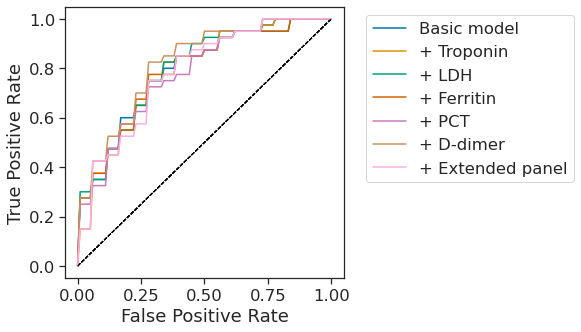

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
for model_name, label, c in zip(model_keys, labels, colours):
    y_true = [x["Test true"] for x in models[model_name]]
    y_score = [x["Test Probs"] for x in models[model_name]]
    roc_curve(y_true, y_score, ax, label, c)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(bbox_to_anchor=(1.05, 1.))
fig.savefig("../figures/complete_case/mortality_roc.svg", bbox_inches="tight")
plt.show()

<h3>Threshold-performance plots</h3>

/home/rossco/CHADBiomarkers/multivariate_models.py:187: RuntimeWarning: invalid value encountered in long_scalars
  return tn/(tn+fn)
/home/rossco/anaconda3/envs/CHAD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rossco/CHADBiomarkers/multivariate_models.py:187: RuntimeWarning: invalid value encountered in long_scalars
  return tn/(tn+fn)
/home/rossco/anaconda3/envs/CHAD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rossco/CHADBiomarkers/multivariate_models.py:187: RuntimeWarning: invalid value encountered in long_sc

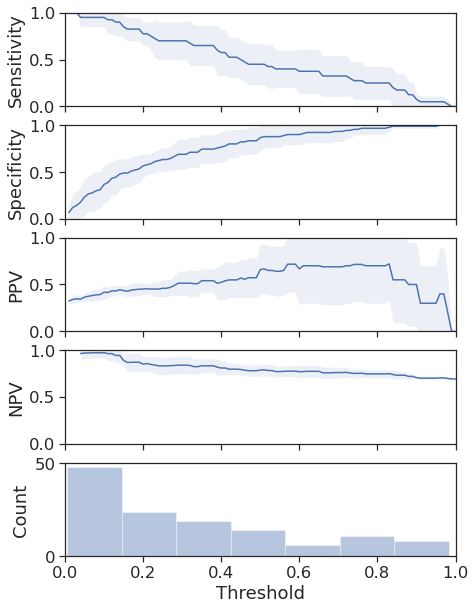

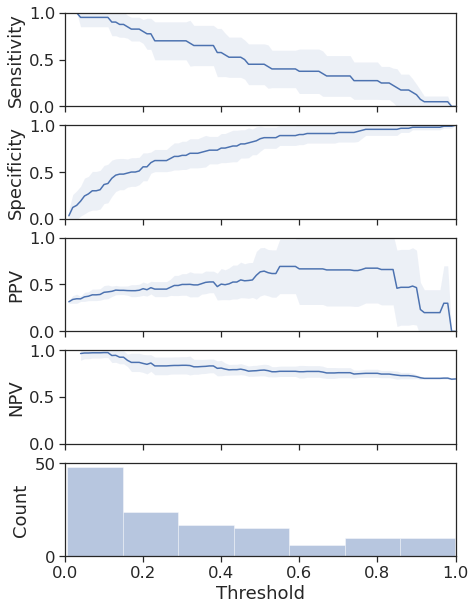

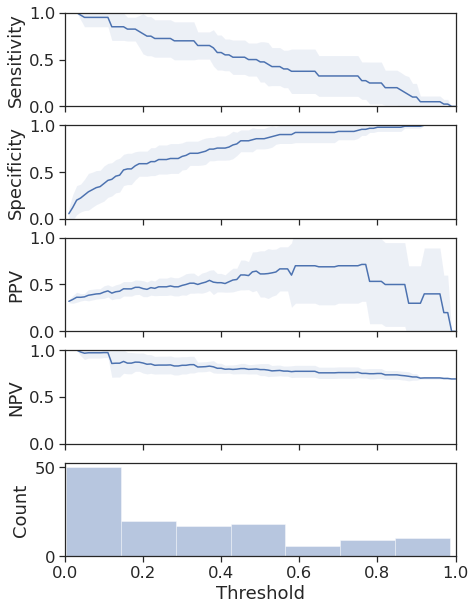

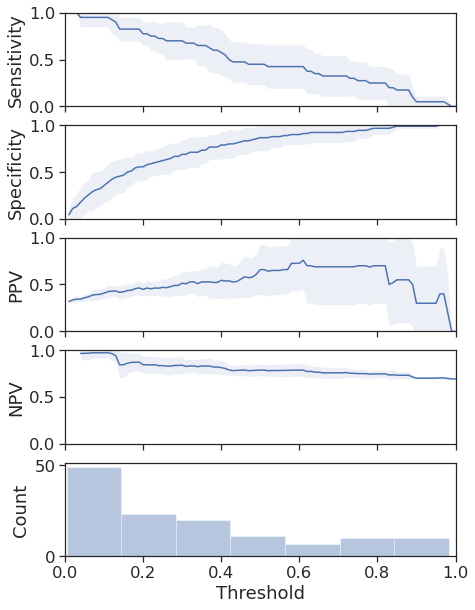

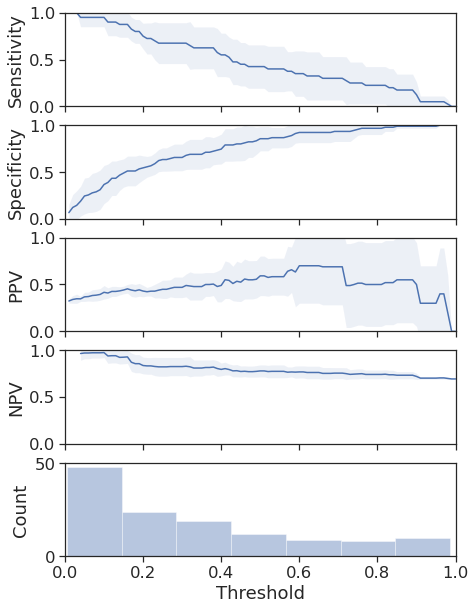

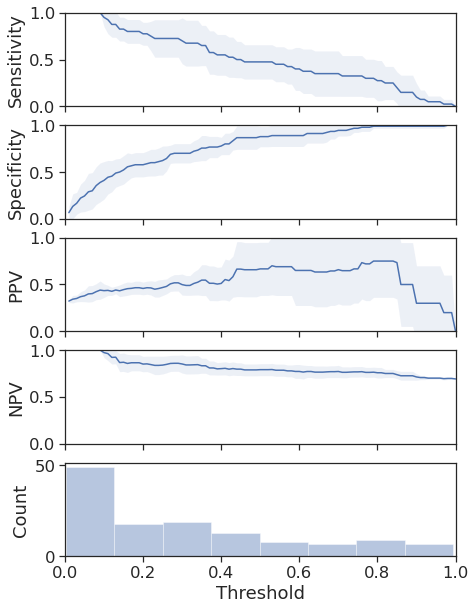

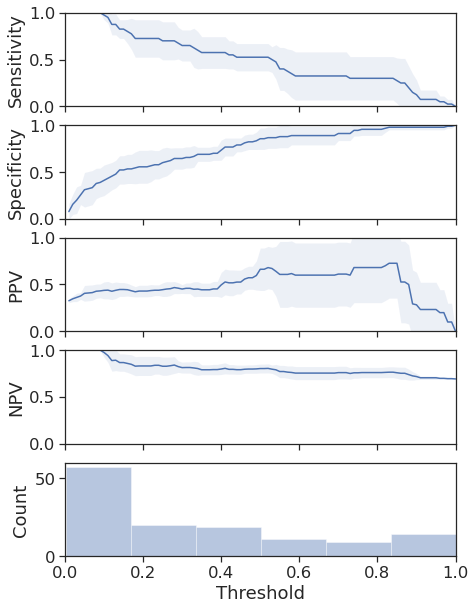

In [20]:
for k in models.keys():
    y_score = [x["Test Probs"] for x in models[k]]
    y_true = [x["Test true"] for x in models[k]]
    fig, axes = threshold_performance_plot(y_score, y_true, figsize=(7,10))
    fig.savefig(f"../figures/complete_case/threshold_performance/{k}_mortality.svg",
                facecolor="white", bbox_inches="tight")

<h3>Coefficients contribution</h3>

In [21]:
import numpy as np
import scipy.stats

auc = list()
pvals = list()
for k in models.keys():
    if k == "Basic model":
        idx = features
    elif k == "Complex model":
        idx = features + extended_panel
    else:
        idx = features + [k]
    p = np.array([x["Model"].results.summary2().tables[1]["P>|z|"].values[1:] 
                  for x in models[k]])
    a = np.array([x["Testing performance"]["AUC Score"] for x in models[k]])
    columns=["Mean", "95% CI [Lower]", "95% CI [Upper]"]
    p = pd.DataFrame([mean_confidence_interval(x) for x in p.T], index=idx, columns=columns)
    p["Model"] = k
    pvals.append(p)
    a = pd.DataFrame(mean_confidence_interval(a.T), index=columns).T
    a["Model"] = k
    auc.append(a)
pd.concat(auc).to_csv("../tables/mortality_auc.csv")
(pd.concat(pvals)
 .reset_index()
 .rename({"index": "Feature"}, axis=1)
 .to_csv("../tables/mortality_pvals.csv"))

<h2>Composite Score</h2>

<h3>Stratified K-folds</h3>

In [22]:
models = defaultdict(list)
skf = StratifiedKFold(n_splits=5, shuffle=False)
print("================================")
print("Base Model...")
for train_idx, test_idx in skf.split(data[features], data["composite"]):
    X_train = data[features].values[train_idx]
    y_train = data["composite"].values[train_idx]
    X_test = data[features].values[test_idx]
    y_test = data["composite"].values[test_idx]
    models["Basic model"].append(fit_and_predict(X_train, X_test, y_train, y_test))
for e in extended_panel:
    updated_features = features + [e]
    print(f"{e}...")
    for train_idx, test_idx in skf.split(data[updated_features], data["composite"]):
        X_train = data[updated_features].values[train_idx]
        y_train = data["composite"].values[train_idx]
        X_test = data[updated_features].values[test_idx]
        y_test = data["composite"].values[test_idx]
        models[e].append(fit_and_predict(X_train, X_test, y_train, y_test))
print("Complex model...")
updated_features = features + extended_panel
for train_idx, test_idx in skf.split(data[updated_features], data["composite"]):
    X_train = data[updated_features].values[train_idx]
    y_train = data["composite"].values[train_idx]
    X_test = data[updated_features].values[test_idx]
    y_test = data["composite"].values[test_idx]
    models["Complex model"].append(fit_and_predict(X_train, X_test, y_train, y_test))
print("Complete!")
print("================================")

Base Model...
High Sensitivity Troponin I...
Lactate dehydrogenase...
Ferritin...
Procalcitonin...
D-dimer...
Complex model...
Complete!


<h3>Learning Curves</h3>

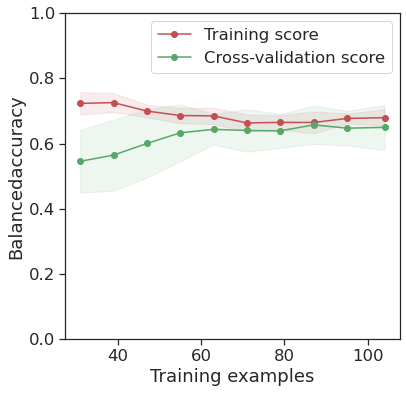

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_learning_curve(data=data, features=features, label="composite",
                    ax=ax)
fig.savefig("../figures/complete_case/learning_curves/composite/basic_model.svg", 
            facecolor="white", bbox_inches="tight")

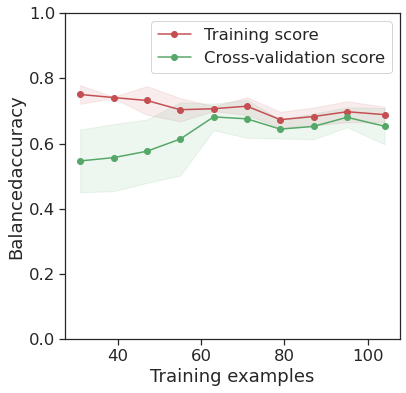

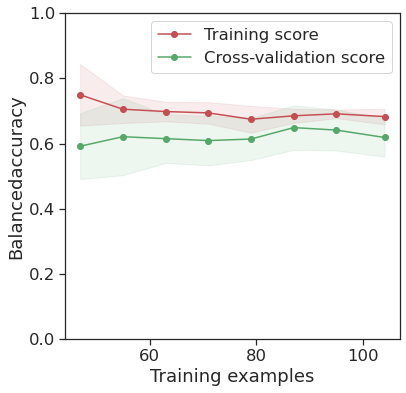

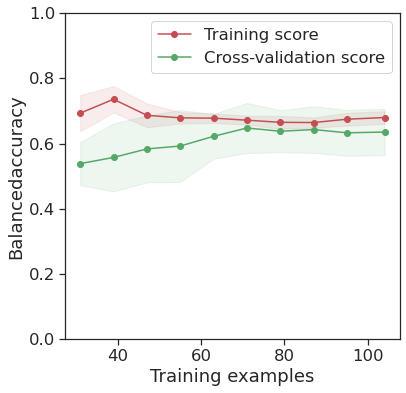

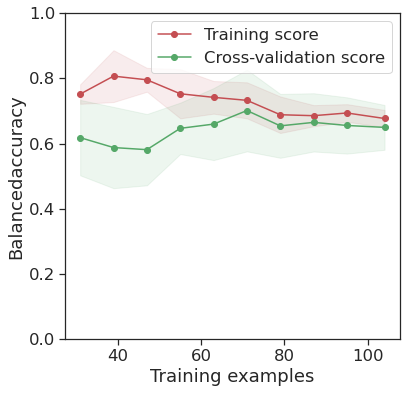

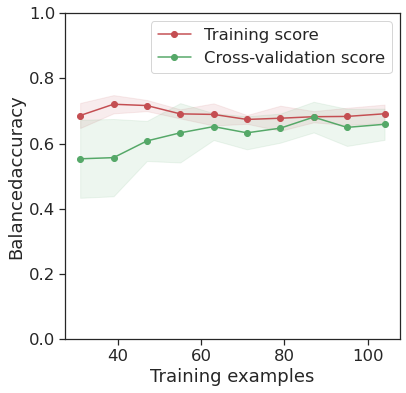

In [24]:
for e in extended_panel:
    updated_features = features + [e]
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_learning_curve(data=data, features=updated_features, label="composite",
                        ax=ax)
    fig.savefig(f"../figures/complete_case/learning_curves/composite/{e}.svg", 
                facecolor="white", bbox_inches="tight")

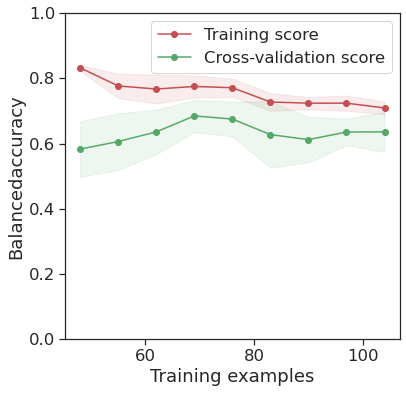

In [25]:
updated_features = features + extended_panel
fig, ax = plt.subplots(figsize=(6, 6))
plot_learning_curve(data=data, features=updated_features, label="composite",
                    ax=ax, train_sizes=np.linspace(0.4, 1, 10))
fig.savefig(f"../figures/complete_case/learning_curves/composite/complex_model.svg", 
            facecolor="white", bbox_inches="tight")

<h3>Model performance</h3>

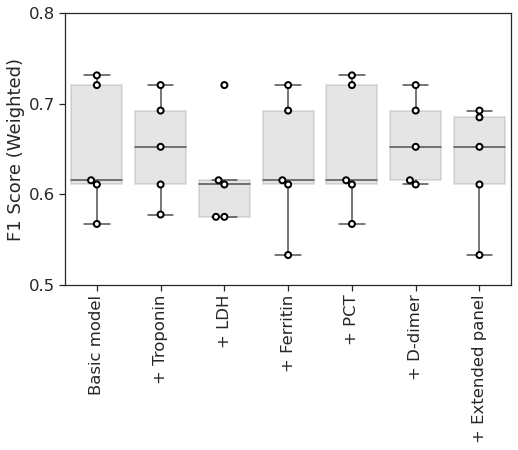

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
box_swarm_models(models, "F1 Score (Weighted)", ax, ylim=(0.5, 0.8), swarm_size=6)
fig.savefig("../figures/complete_case/composite_f1score.svg", 
            facecolor="white", bbox_inches="tight")

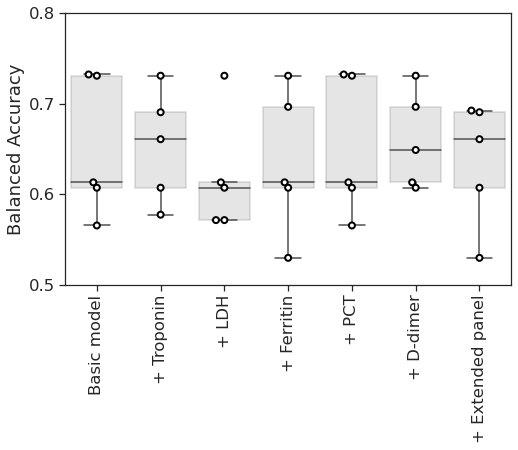

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
box_swarm_models(models, "Balanced Accuracy", ax, ylim=(0.5, 0.8), swarm_size=6)
fig.savefig("../figures/complete_case/composite_acc.svg", 
            facecolor="white", bbox_inches="tight")

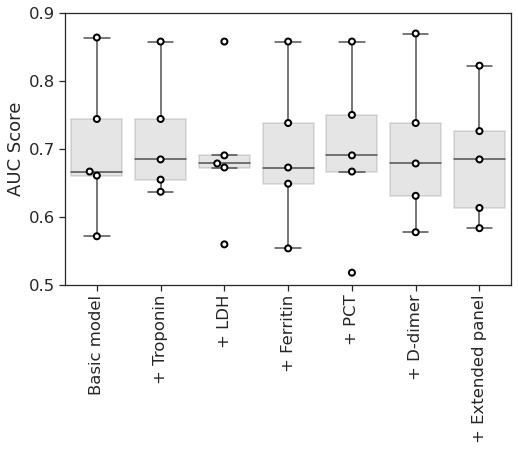

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
box_swarm_models(models, "AUC Score", ax, ylim=(0.5, 0.9), swarm_size=6)
fig.savefig("../figures/complete_case/composite_auc.svg", 
            facecolor="white", bbox_inches="tight")

<h3>ROC Curves</h3>

In [29]:
model_keys = ['Basic model', 'High Sensitivity Troponin I', 'Lactate dehydrogenase', 
              'Ferritin', 'Procalcitonin', 'D-dimer', 'Complex model']
labels = ["Basic model",
          "+ Troponin",
          "+ LDH",
          "+ Ferritin",
          "+ PCT",
          "+ D-dimer",
          "+ Extended panel"]

In [30]:
colours = sns.color_palette("colorblind")[0:7]

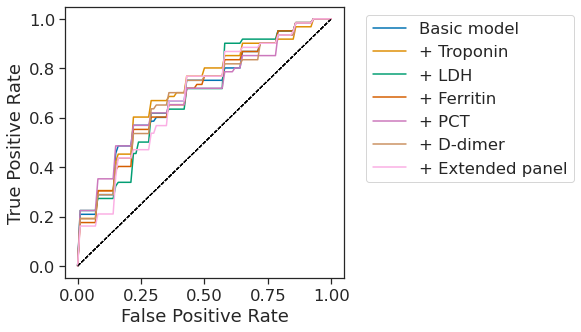

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
for model_name, label, c in zip(model_keys, labels, colours):
    y_true = [x["Test true"] for x in models[model_name]]
    y_score = [x["Test Probs"] for x in models[model_name]]
    roc_curve(y_true, y_score, ax, label, c)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(bbox_to_anchor=(1.05, 1.))
fig.savefig("../figures/complete_case/composite_roc.svg", bbox_inches="tight")
plt.show()

<h3>Threshold-performance plots</h3>

/home/rossco/CHADBiomarkers/multivariate_models.py:187: RuntimeWarning: invalid value encountered in long_scalars
  return tn/(tn+fn)
/home/rossco/anaconda3/envs/CHAD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rossco/CHADBiomarkers/multivariate_models.py:187: RuntimeWarning: invalid value encountered in long_scalars
  return tn/(tn+fn)
/home/rossco/anaconda3/envs/CHAD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rossco/CHADBiomarkers/multivariate_models.py:187: RuntimeWarning: invalid value encountered in long_sc

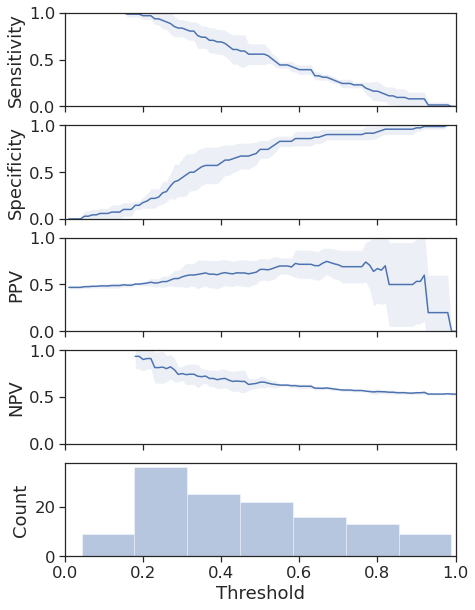

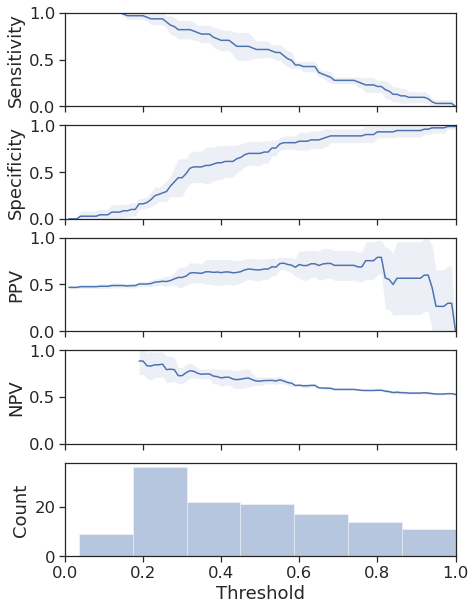

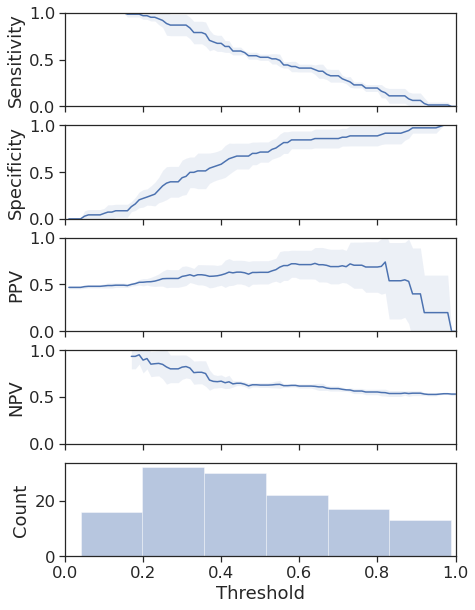

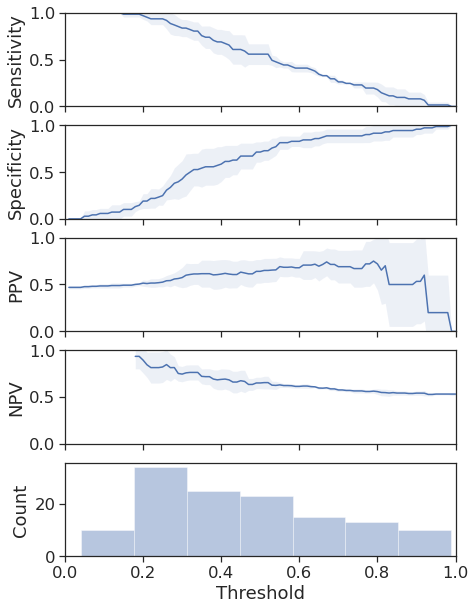

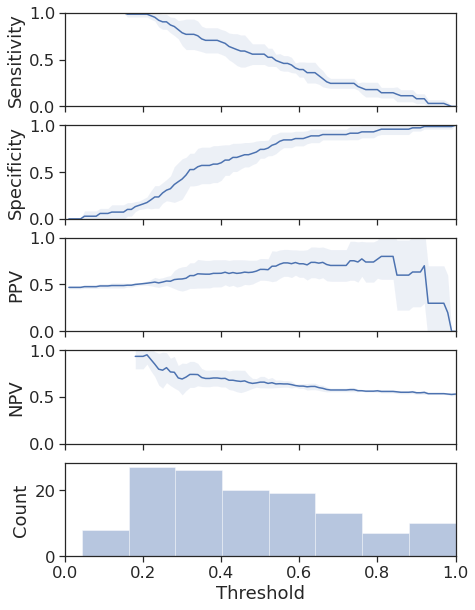

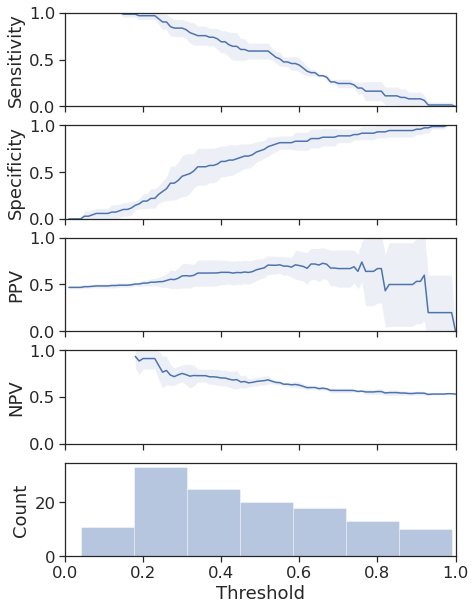

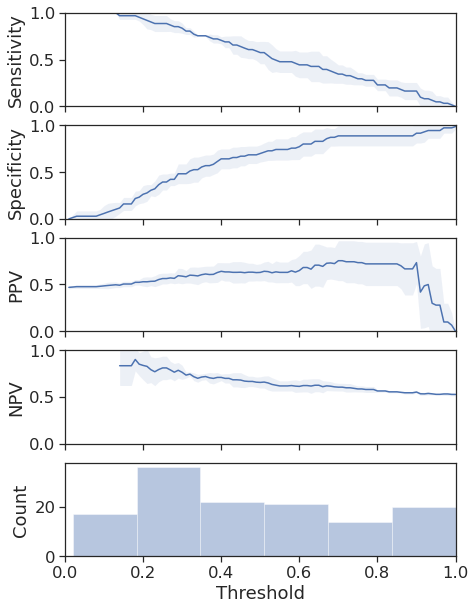

In [32]:
for k in models.keys():
    y_score = [x["Test Probs"] for x in models[k]]
    y_true = [x["Test true"] for x in models[k]]
    fig, axes = threshold_performance_plot(y_score, y_true, figsize=(7,10))
    fig.savefig(f"../figures/complete_case/threshold_performance/{k}_composite.svg",
                facecolor="white", bbox_inches="tight")

<h3>Coefficients contribution</h3>

In [33]:
auc = list()
pvals = list()
for k in models.keys():
    if k == "Basic model":
        idx = features
    elif k == "Complex model":
        idx = features + extended_panel
    else:
        idx = features + [k]
    p = np.array([x["Model"].results.summary2().tables[1]["P>|z|"].values[1:] 
                  for x in models[k]])
    a = np.array([x["Testing performance"]["AUC Score"] for x in models[k]])
    columns=["Mean", "95% CI [Lower]", "95% CI [Upper]"]
    p = pd.DataFrame([mean_confidence_interval(x) for x in p.T], index=idx, columns=columns)
    p["Model"] = k
    pvals.append(p)
    a = pd.DataFrame(mean_confidence_interval(a.T), index=columns).T
    a["Model"] = k
    auc.append(a)
pd.concat(auc).to_csv("../tables/composite_auc.csv")
(pd.concat(pvals)
 .reset_index()
 .rename({"index": "Feature"}, axis=1)
 .to_csv("../tables/composite_pvals.csv"))